# Question1

# Restricted Boltzmann Machine 

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import random
import scipy.misc
import keras
import tensorflow as tf
import os
from skimage import io
from tensorflow.contrib.slim import fully_connected as ful_con
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Loading mnist dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizing the dataset
x_train = x_train / 255
x_test = x_test / 255

# Binarizing the dataset
x_train[x_train >= .5] = 1.
x_train[x_train < .5] = 0.
x_test[x_test >= .5] = 1.
x_test[x_test < .5] = 0.

In [0]:
class Data_set:
    
    def __init__(self, raw_input, target, batch_size = None):
        self.raw_input = raw_input
        self.target = target
        self.raw_input = self.raw_input.reshape([self.raw_input.shape[0],self.raw_input.shape[1] * self.raw_input.shape[2]])
        if batch_size == None:
            self.batch_size = self.raw_input.shape[0]
        else:
            self.batch_size = batch_size
        self.batch_num = int(self.raw_input.shape[0] / self.batch_size)
        idx = np.random.permutation(self.raw_input.shape[0])
        self.raw_input = self.raw_input[idx]
        self.target = self.target[idx]
        self.target= keras.utils.to_categorical(self.target)
        self.batch_index = 0

    def IteratingBatch(self):
        strt = self.batch_index * self.batch_size
        end = (self.batch_index + 1) * self.batch_size
        self.batch_index = (self.batch_index + 1) % self.batch_num
        return self.raw_input[strt:end, :], self.target[strt:end, :]
        
    def batchFromSample(self):
        index = random.randrange(self.batch_num)
        strt = index * self.batch_size
        end = (index + 1) * self.batch_size
        return self.raw_input[strt:end, :], self.target[strt:end, :]     

# Defining a function (XsetContaMissingPix()) that will return by including missing pixels in X_test

In [0]:
def XsetContaMissingPix(testSet, value):
    testData = np.copy(testSet)
    size = testData.shape[1] * testData.shape[2]
    num = int((value * size) / 100)
    for i in range(testData.shape[0]):
        idx = []
        for _ in range(num):
            idx.append(np.random.randint(0,size))
        imd_term = testData[i].flatten() 
        imd_term[idx] = 0
        testData[i] = imd_term.reshape((testData.shape[1], testData.shape[2]))
    return testData

In [0]:
# we are passing 20 % as an argument to XsetContaMissingPix() function that will include 20% missing pixels in the X_test
value = 20
x_test_20 = XsetContaMissingPix(x_test, value)

In [0]:
# we are passing 50 % as an argument to XsetContaMissingPix() function that will include 50% missing pixels in the X_test
value = 50
x_test_50 = XsetContaMissingPix(x_test, value)

In [0]:
# we are passing 80 % as an argument to XsetContaMissingPix() function that will include 80% missing pixels in the X_test
value = 80
x_test_80 = XsetContaMissingPix(x_test, value)

In [0]:
def weightVariable(shape, name='weights'):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

In [0]:
def biasVariables(shape, name='biases'):
    return tf.Variable(tf.constant(0.1, shape=shape), name=name)

In [0]:
def plotImages(file):
    fig =plt.figure(figsize=(22,16))
    fig.subplots_adjust(wspace=0.3,hspace=0.6)
    step = 1
    for i in os.listdir(file)[-3:-1]:
        image = io.imread(file + "/" + i)
        ax = fig.add_subplot(1,2,step)
        plt.imshow(image, cmap= "gray")
        plt.title(i)
        step += 1

# Restricted Boltzmann Machine 

In [0]:
class RestrictedBoltzmannMachine:
    def __init__(self, visible_units = 784, hidden_units = 400, k = 25, momentum = False):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.k = k
        self.lr = tf.placeholder(tf.float32)
        if momentum:
            self.momentum = tf.placeholder(tf.float32)
        else:
            self.momentum = 0.0
        self.w = weightVariable([visible_units, hidden_units], 'w')
        self.hb = biasVariables([hidden_units], 'hb')
        self.vb = biasVariables([visible_units], 'vb')
        self.w_v = tf.Variable(tf.zeros([visible_units, hidden_units]), dtype=tf.float32)
        self.hb_v = tf.Variable(tf.zeros([hidden_units]), dtype=tf.float32)
        self.vb_v = tf.Variable(tf.zeros([visible_units]), dtype=tf.float32)
       
    def propagateForward(self, visible):
        pre_sigmoid_activation = tf.matmul(visible, self.w) + self.hb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def propagateBackward(self, hidden):
        pre_sigmoid_activation = tf.matmul(hidden, tf.transpose(self.w)) + self.vb
        return tf.nn.sigmoid(pre_sigmoid_activation)
    
    def sample_h_given_v(self, sample_v):
        h_props = self.propagateForward(sample_v)
        sample_h = tf.nn.relu(tf.sign(h_props - tf.random_uniform(tf.shape(h_props))))
        return sample_h
    
    def sample_v_given_h(self, sample_h):
        v_props = self.propagateBackward(sample_h)
        sample_v = tf.nn.relu(tf.sign(v_props - tf.random_uniform(tf.shape(v_props))))
        return sample_v
    
    def contrastiveDivergence(self, visibles):       
        samples_v = visibles
        samples_h = self.sample_h_given_v(samples_v)
        for i in range(self.k):
            samples_v = self.sample_v_given_h(samples_h)
            samples_h = self.sample_h_given_v(samples_v)
        
        h0_props = self.propagateForward(visibles)
        positive_w = tf.matmul(tf.transpose(visibles), h0_props)
        negative_w = tf.matmul(tf.transpose(samples_v), samples_h)
        grad_w = (positive_w - negative_w) / tf.to_float(tf.shape(visibles)[0])
        grad_hb = tf.reduce_mean(h0_props - samples_h, 0)
        grad_vb = tf.reduce_mean(visibles - samples_v, 0)
        return grad_w, grad_hb, grad_vb
    
    def Parameters_update(self, visibles):
        grad_w, grad_hb, grad_vb = self.contrastiveDivergence(visibles)
        new_w_v = self.momentum * self.w_v + self.lr * grad_w
        new_hb_v = self.momentum * self.hb_v + self.lr * grad_hb
        new_vb_v = self.momentum * self.vb_v + self.lr * grad_vb
        update_w = tf.assign(self.w, self.w + new_w_v)
        update_hb = tf.assign(self.hb, self.hb + new_hb_v)
        update_vb = tf.assign(self.vb, self.vb + new_vb_v)
        update_w_v = tf.assign(self.w_v, new_w_v)
        update_hb_v = tf.assign(self.hb_v, new_hb_v)
        update_vb_v = tf.assign(self.vb_v, new_vb_v)
        return [update_w, update_hb, update_vb, update_w_v, update_hb_v, update_vb_v]
        
    def drawFromSample(self, visibles, steps=5000):
        samples_v = visibles
        for step in range(steps):
            samples_v = self.sample_v_given_h(self.sample_h_given_v(samples_v))
        return samples_v
    
    def energy_func(self, visibles):
        first_term = tf.matmul(visibles, tf.reshape(self.vb, [tf.shape(self.vb)[0], 1]))
        second_term = tf.reduce_sum(tf.log(1 + tf.exp(self.hb + tf.matmul(visibles, self.w))), axis=1)
        return - first_term - second_term
    i = 0
    def log_likelihood(self, visibles):
        x = tf.round(visibles)
        x_fe = self.energy_func(x)
        split0, split1, split2 = tf.split(x, [self.i, 1, tf.shape(x)[1] - self.i - 1], 1)
        xi = tf.concat([split0, 1 - split1, split2], 1)
        self.i = (self.i + 1) % self.visible_units
        xi_fe = self.energy_func(xi)
        return tf.reduce_mean(self.visible_units * tf.log(tf.nn.sigmoid(xi_fe - x_fe)), axis=0)

In [0]:
def save_images(images, size, path):
    img = (images + 1.0) / 2.0
    h, w = img.shape[1], img.shape[2]
    merge_img = np.zeros((h * size[0], w * size[1]))
    
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        merge_img[j*h:j*h+h, i*w:i*w+w] = image
    
    return scipy.misc.imsave(path, merge_img)

In [0]:
os.chdir("/content/drive/My Drive")

In [0]:
def training(trainngData, epochs,folder, hidden_units):
    
    ip_x = tf.placeholder(tf.float32, shape=[None, 784])
    doped_x, _ = trainngData.batchFromSample()
    model = RestrictedBoltzmannMachine(hidden_units = hidden_units)
    step = model.Parameters_update(ip_x)
    sampler = model.drawFromSample(ip_x)
    likelihood = model.log_likelihood(ip_x)
    os.mkdir(folder)
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        mean_cost = []
        epoch = 1
        for i in range(epochs * trainngData.batch_num):
            if i % 500 == 0:
                samples = sess.run(sampler, feed_dict = {ip_x: doped_x})
                samples = samples.reshape([trainngData.batch_size, 28, 28])
                save_images(samples, [8, 8], os.path.join(folder, 'iteration_%d.png' % i))
        
            batch_x, _ = trainngData.IteratingBatch()
            sess.run(step, feed_dict = {ip_x: batch_x, model.lr: 0.12})
            cost = sess.run(likelihood, feed_dict = {ip_x: batch_x})
            mean_cost.append(cost)
          
            if i != 0 and trainngData.batch_index == 0:
                mean_cost = []
                epoch += 1
        print("\nAll epochs Done!")
        samples = sess.run(sampler, feed_dict = {ip_x: doped_x})
        samples = samples.reshape([trainngData.batch_size, 28, 28])
        save_images(samples, [8, 8], os.path.join(folder, 'test.png'))

In [0]:
trainngData = Data_set(x_train, y_train, batch_size=64)

In [17]:
# Training Restricted Boltzmann Machine with 20 hidden units
fol_20 = "fol_20" 
hidden_units = 20
training(trainngData, 25, fol_20, hidden_units)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()



All epochs Done!


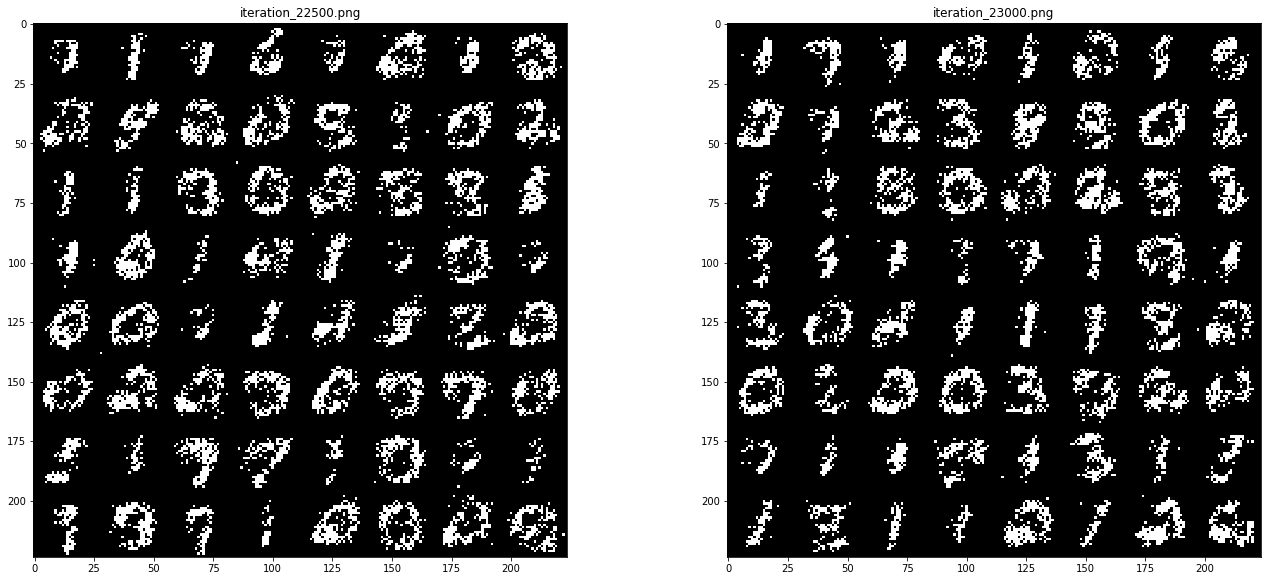

In [18]:
# plotting images
plotImages(fol_20)

In [19]:
# Training Restricted Boltzmann Machine with 100 hidden units
fol_100 = "fol_100" 
hidden_units = 100
training(trainngData, 25, fol_100, hidden_units)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()



All epochs Done!


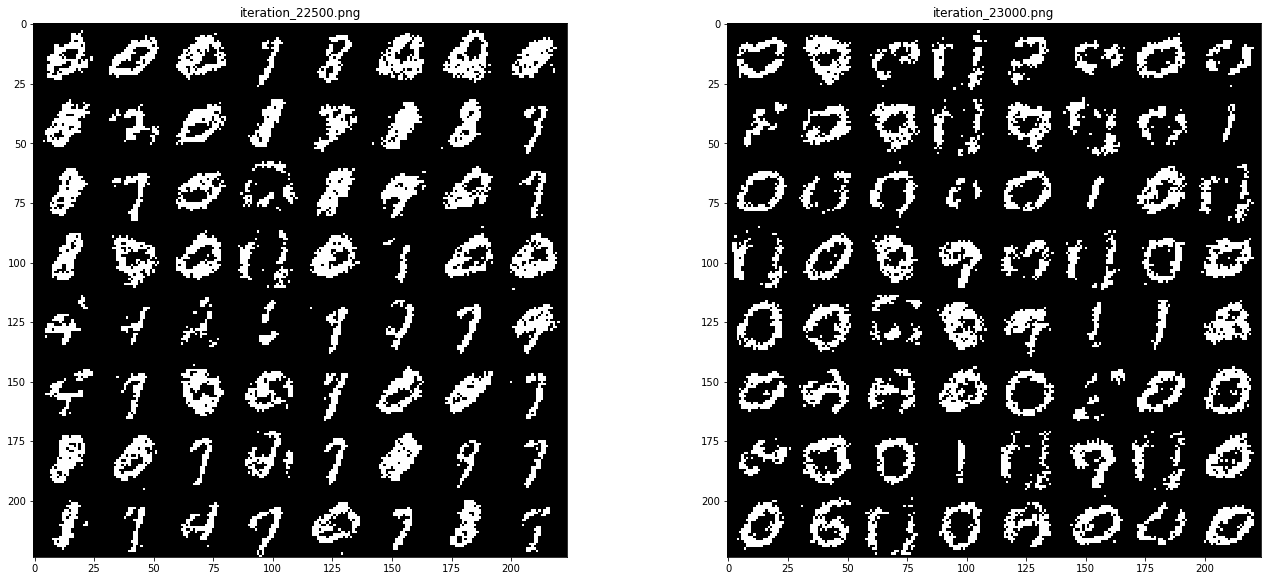

In [20]:
# plotting images
plotImages(fol_100)

In [21]:
# Training Restricted Boltzmann Machine with 500 hidden units
fol_500 = "fol_500" 
hidden_units = 500
training(trainngData, 25, fol_500, hidden_units)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()



All epochs Done!


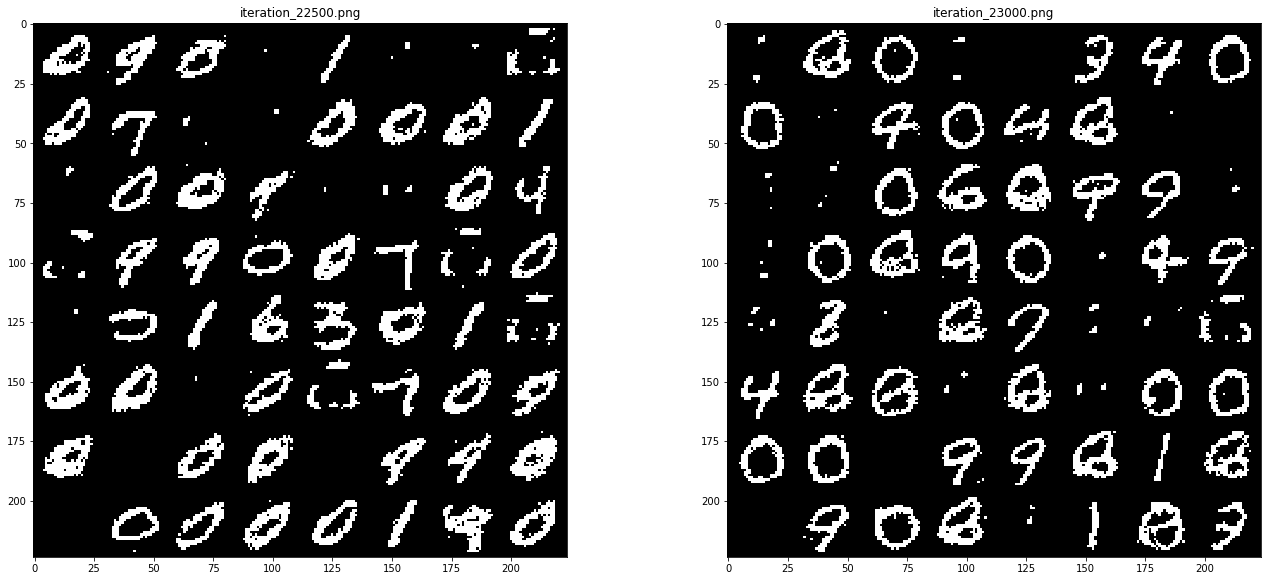

In [22]:
# plotting images
plotImages(fol_500)

In [23]:
fol_miss20 = "fol_miss20" 
hidden_units = 500
test_data = Data_set(x_test_20, y_test, batch_size=64)
training(test_data, 25, fol_miss20, hidden_units)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()



All epochs Done!


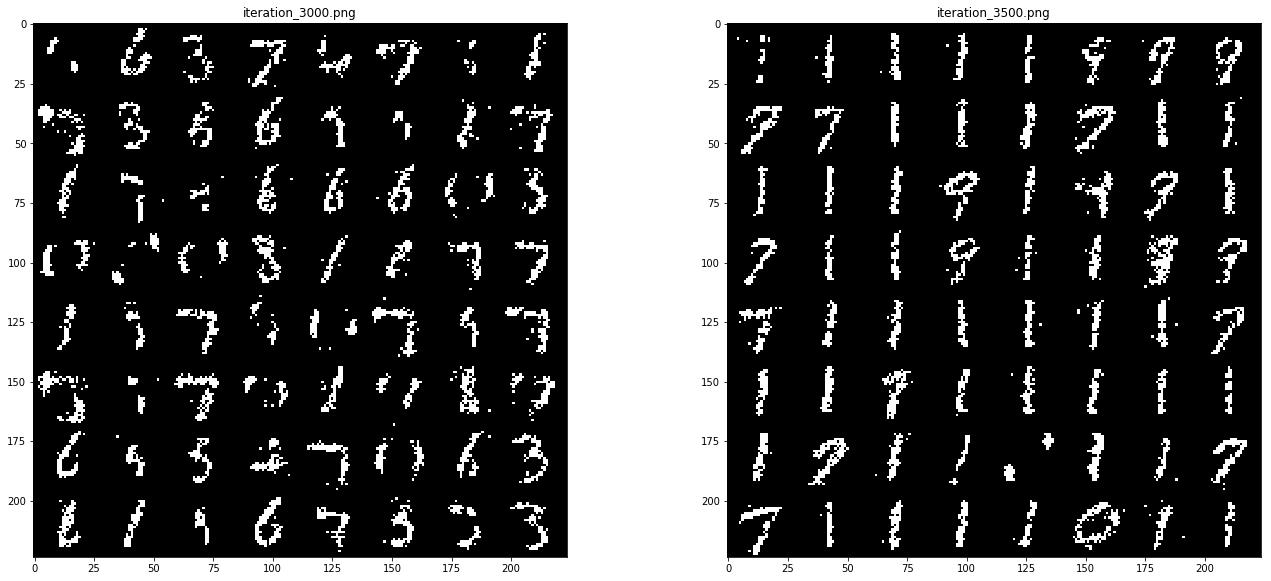

In [24]:
# plotting images in which 20% pixels are missing
plotImages(fol_miss20)

In [25]:
fol_miss50 = "fol_miss50" 
hidden_units = 500
test_data = Data_set(x_test_50, y_test, batch_size=64)
training(test_data, 25, fol_miss50, hidden_units)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()



All epochs Done!


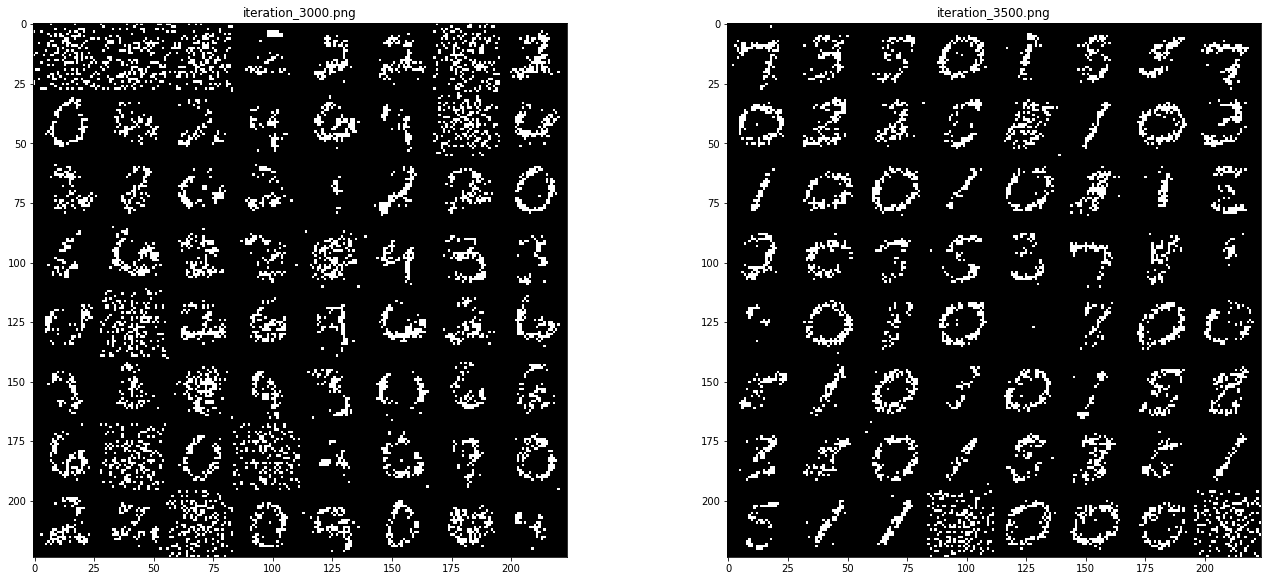

In [26]:
# plotting images in which 50% pixels are missing
plotImages(fol_miss50)

In [17]:
fol_miss80 = "fol_miss80" 
hidden_units = 500
test_data = Data_set(x_test_80, y_test, batch_size=64)
training(test_data, 25, fol_miss80, hidden_units)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()



All epochs Done!


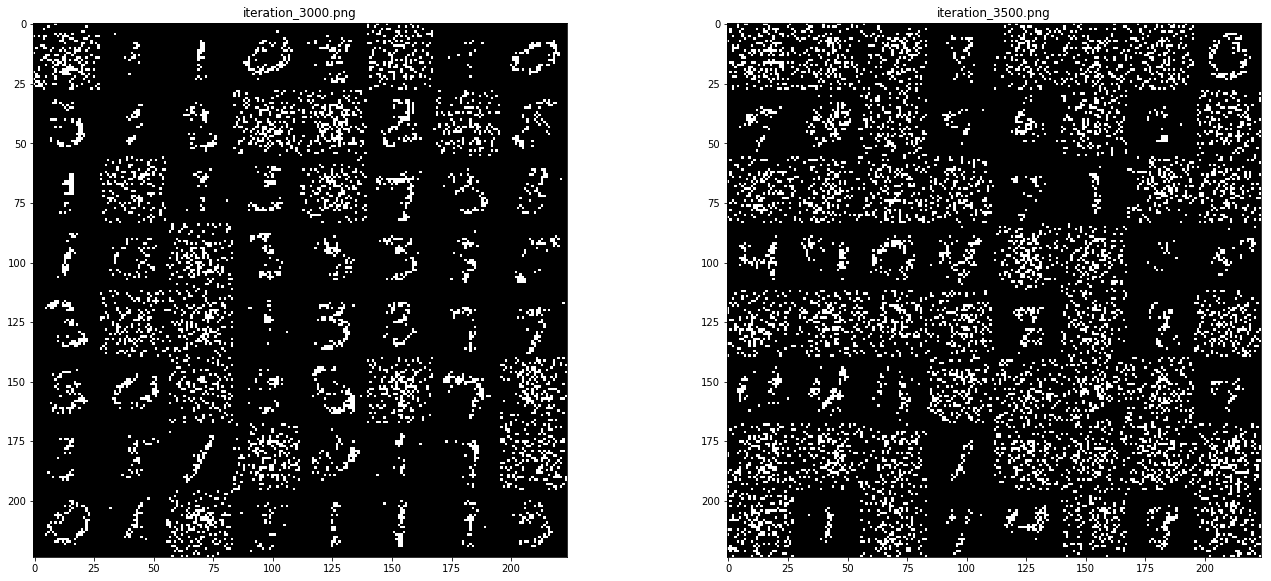

In [18]:
# plotting images in which 80% pixels are missing
plotImages(fol_miss80)

# Question2

# Variational autoencoder

In [0]:
dataset = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = dataset.train.num_examples
input_dim = dataset.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

In [0]:
class VariationalAutoencoder:

    def __init__(self, lr = 0.1, batch_size = 64, code_units = 8):
        
        self.batch_size = batch_size
        self.code_units = code_units
        self.lr = lr
        tf.reset_default_graph()
        self.structure()
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

        
    # Defining encoder and decoder
    
    def structure(self):
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        fc1 = ful_con(self.x, 256, scope='enc_ful_con1', activation_fn=tf.nn.relu)
        self.z_mu = ful_con(fc1, self.code_units, scope='enc_ful_con2_mu', 
                       activation_fn=None)
        self.z_log_sigma_sq = ful_con(fc1, self.code_units, scope='enc_ful_con2_sigma', 
                                 activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        gc1 = ful_con(self.z, 256, scope='dec_ful_con1', activation_fn=tf.nn.relu)
        self.x_hat = ful_con(gc1, input_dim, scope='dec_ful_con2', 
                        activation_fn=tf.sigmoid)

        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate = self.lr).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        

    def forw_back_pass(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    def reformation(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

In [0]:
def train(object_, lr = 1e-4, 
            batch_size=64, num_epoch=90, code_units = 2):
    model = object_(lr=lr, batch_size=batch_size, code_units = code_units)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            batch = dataset.train.next_batch(batch_size)
            losses = model.forw_back_pass(batch[0])
    print("All Epochs completed!")   
    return model

In [22]:
# Training Variational autoencoder classifier with code unit(z) two
clf_z_2 = train(VariationalAutoencoder, code_units = 2)

Instructions for updating:
Use tf.cast instead.
All Epochs completed!


In [0]:
def validate(model, dataset, h=28, w=28, batch_size=100):
    batch = dataset.test.next_batch(batch_size)
    x_reconstructed = model.reformation(batch[0])
    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

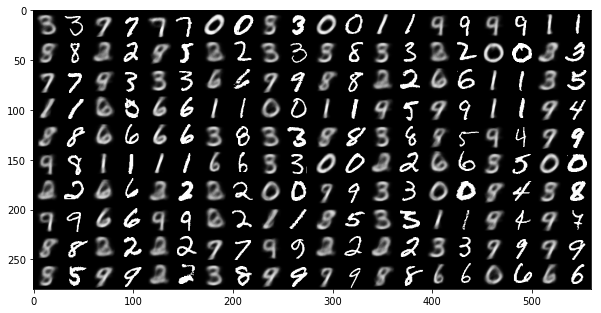

In [24]:
# Inference by classifeir clf_z_2
validate(clf_z_2, dataset)

In [25]:
# Training Variational autoencoder classifier with code unit(z) eight
clf_z_8 = train(VariationalAutoencoder, code_units = 8)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


All Epochs completed!


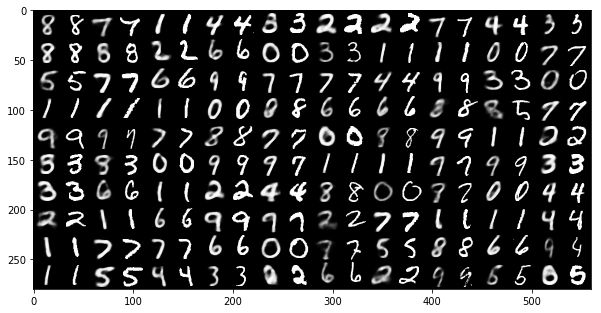

In [26]:
# Inference by classifeir clf_z_8
validate(clf_z_8, dataset)

In [27]:
# Training Variational autoencoder classifier with code unit(z) sixteen
clf_z_16 = train(VariationalAutoencoder, code_units = 16)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


All Epochs completed!


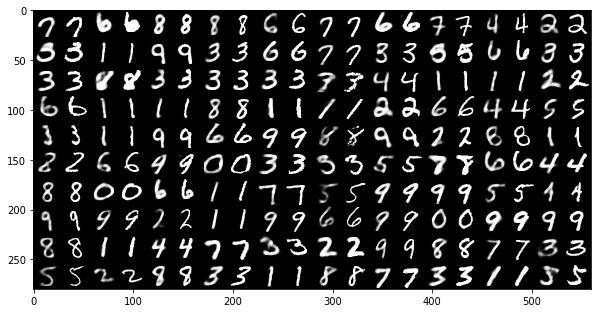

In [28]:
# Inference by classifeir clf_z_16
validate(clf_z_16, dataset)

# Question3 

# Convolutional Variational Autoencoder

In [0]:
data_input = tf.placeholder(tf.float32,[None,28,28,1])
tar = tf.placeholder(tf.float32,[None,28,28,1])
activation_func = lambda l:tf.maximum(0.1*l,l)

In [30]:
# Encoder and decoder Convolution

conv1 = tf.layers.conv2d(data_input,filters=32,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation = activation_func,name='conv1')
maxpool1 = tf.layers.max_pooling2d(conv1,pool_size=(2,2),strides=(2,2),name='pool1')
conv2 = tf.layers.conv2d(maxpool1,filters=32,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation = activation_func,name='conv2')
encoded = tf.layers.max_pooling2d(conv2,pool_size=(2,2),strides=(2,2),name='encoding')
conv3 = tf.layers.conv2d(encoded,filters=32,kernel_size=(3,3),strides=(1,1),name='conv3',padding='SAME',use_bias=True,activation = activation_func)        
upsample1 = tf.layers.conv2d_transpose(conv3,filters=32,kernel_size=3,padding='same',strides=2,name='upsample1')
upsample2 = tf.layers.conv2d_transpose(upsample1,filters=32,kernel_size=3,padding='same',strides=2,name='upsample2')
logits = tf.layers.conv2d(upsample2,filters=1,kernel_size=(3,3),strides=(1,1),name='logits',padding='SAME',use_bias=True)
decoded = tf.sigmoid(logits,name='recon')

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


In [0]:
# Loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels = tar)
learning_rate=tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss) 
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

All Epochs Completed!
original Images


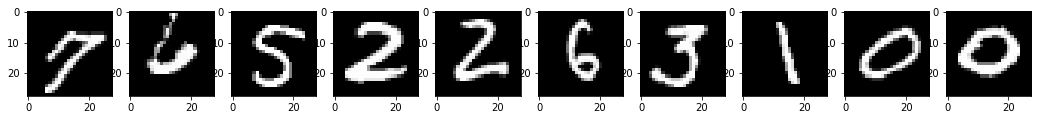

Reformed Images


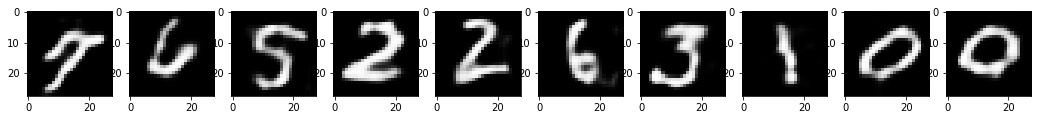

In [32]:
# Inference

sess = tf.Session()
epochs = 35
batch_size = 64
lr=1e-5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    total_batch = int(dataset.train.num_examples/batch_size)
    for ibatch in range(total_batch):
        batch_x = dataset.train.next_batch(batch_size)
        batch_test_x= dataset.test.next_batch(batch_size)
        imgs_test = batch_x[0].reshape((-1, 28, 28, 1))
        x_test = imgs_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=imgs_test.shape) 
        x_test = np.clip(x_test, 0., 1.)
        imgs = batch_x[0].reshape((-1, 28, 28, 1))
        x_train = imgs + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape) 
        x_train = np.clip(x_train, 0., 1.)
        batch_cost, _ = sess.run([cost, opt], feed_dict={data_input: x_train,tar: imgs,learning_rate:lr})
      
        batch_cost_test = sess.run(cost, feed_dict={data_input: x_test,tar: imgs_test})

print("All Epochs Completed!")     

batch_x= dataset.test.next_batch(10)
imgs = batch_x[0].reshape((-1, 28, 28, 1))
x_test = imgs + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape) 
x_test = np.clip(x_test, 0., 1.)
recon_img = sess.run([decoded], feed_dict={data_input: x_test})[0]
plt.figure(figsize=(18, 4))
print("original Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(imgs[i, ..., 0], cmap='gray')   
plt.show()
print("Reformed Images")
plt.figure(figsize=(18, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(recon_img[i, ..., 0], cmap='gray')       
sess.close()